# Задача матчинга

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

В нашем распоряжении датасеты с полностью анонимизированными признаками. Задача заключается в том чтобы соотнести запросы из train и validation датасетов с объектами из base на основании их схожести и найти 5 наиболее близких объекта к каждому запросу.

<b>Описание данных</b>

* `train` - датасет, который содержит объекты, которым необходимо подобрать наиболее подходящие из `base`
* `base` - датасет, который содержит объекты, с которыми необходимо соонтнести объекты
* `validation` - датасет, который содержит объекты для валидации
 
Поскольку датасеты содержат большое количество данных (`base` - около 3 миллионов строк), были подготовлены мини датасеты для подбора лучшей модели.

В ходе проекта мы пройдём следующие этапы:

* загрузка и ознакомление с данными
* предобработка данных
* выбор лучшей модели матчинга
* получение предсказаний на валидационной выборке
* итоговая оценка качества лучшей модели

## Загрузка данных.

Загрузим данные и посмотрим общую информацию о них.

In [1]:
import pandas as pd

import numpy as np
from numpy.random import RandomState

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import statistics as st
import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import time

import faiss

C:\Users\Katya\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Напишем функцию, которая загружает данные. Если указан параметр kind='mini', функция загружает мини датасеты.

In [2]:
def load_data(path, kind='mini'):
    if kind=='mini':
        try:
            base = pd.read_csv(path + 'base_mini.csv', index_col = 0)
            train = pd.read_csv(path + 'train_mini.csv', index_col = 0)
            validation = pd.read_csv(path + 'validation_mini.csv', index_col = 0)
            validation_answer = pd.read_csv(path + 'validation_answer_mini.csv', index_col = 0)
        except FileNotFoundError:
            print('Данные не найдены')
    else:
        try:
            base = pd.read_csv(path + 'base.csv', index_col = 0)
            train = pd.read_csv(path + 'train.csv', index_col = 0)
            validation = pd.read_csv(path + 'validation.csv', index_col = 0)
            validation_answer = pd.read_csv(path + 'validation_answer.csv', index_col = 0)
        except FileNotFoundError:
            print('Данные не найдены')
    return base, train, validation, validation_answer

In [3]:
# Функция для описания данных
def describe_data(data):
    display(data.head())
    display(data.info())
    print('Описание')
    display(data.describe)

#### Загрузка данных

Загрузим также мини наборы данных для более быстрых тестов.

In [4]:
path = 'C:/Users/Katya/Desktop/ds_learning/18sprint_masterskaya_2/matching/'

In [5]:
base, train, validation, validation_answer = load_data(path, 'full')

In [6]:
for i in [base, train, validation, validation_answer]:
    describe_data(i)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

Описание


<bound method NDFrame.describe of                        0          1          2          3           4  \
Id                                                                      
0-base       -115.083890  11.152912 -64.426760 -118.88089  216.482440   
1-base        -34.562202  13.332763 -69.787610 -166.53348   57.680607   
2-base        -54.233746   6.379371 -29.210136 -133.41383  150.895830   
3-base        -87.520130   4.037884 -87.803030 -185.06763   76.369540   
4-base        -72.743850   6.522049  43.671265 -140.60803    5.820023   
...                  ...        ...        ...        ...         ...   
4744755-base -125.086300   4.735448  38.284935 -125.27671  209.788360   
4744759-base -108.598390   5.454173 -22.191975 -158.71666  113.606110   
4744762-base  -97.026730  -2.143885 -71.274090 -144.68066  149.464810   
4744763-base  -86.838430   8.911945 -34.837738 -106.46268   42.236572   
4744766-base -101.965270  12.859500 -51.393135 -168.21826  101.065110   

                

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

Описание


<bound method NDFrame.describe of                      0          1           2           3           4  \
Id                                                                      
0-query     -53.882748  17.971436  -42.117104 -183.936680  187.517490   
1-query     -87.776370   6.806268  -32.054546 -177.260390  120.803330   
2-query     -49.979565   3.841486 -116.118590 -180.401980  190.128430   
3-query     -47.810562   9.086598 -115.401695 -121.011360   94.652840   
4-query     -79.632126  14.442886  -58.903397 -147.052540   57.127068   
...                ...        ...         ...         ...         ...   
99995-query -68.180530  11.657515  -63.179720 -188.726530  131.113100   
99996-query -66.540890   2.201112  -70.292114 -146.167850   77.817140   
99997-query -53.948240   4.726887  -29.278950 -147.182830  264.090670   
99998-query -77.321770  10.120371  -63.995037 -115.817314  140.170430   
99999-query -89.048460  10.938594  -53.206207 -144.188580  143.445330   

                

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

None

Описание


<bound method NDFrame.describe of                       0          1          2           3           4  \
Id                                                                      
100000-query -57.372734   3.597752 -13.213642 -125.926790  110.745940   
100001-query -53.758705  12.790300 -43.268543 -134.417620  114.449910   
100002-query -64.175095  -3.980927  -7.679249 -170.160930   96.446160   
100003-query -99.286860  16.123936   9.837166 -148.060440   83.697080   
100004-query -79.532920  -0.364173 -16.027431 -170.884950  165.453920   
...                 ...        ...        ...         ...         ...   
199995-query -46.672780   6.644193   7.376480 -116.126400   80.031715   
199996-query -94.786316  10.852646  13.700245 -125.619385   21.545967   
199997-query -59.224453  13.585838  22.655106 -134.926030  145.205690   
199998-query -33.353630  11.671304 -31.577808 -127.493970   75.580860   
199999-query -40.757560   6.832712 -29.993444 -156.309200  108.846780   

                

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

Описание


<bound method NDFrame.describe of                   Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base
...                    ...
199995-query   967418-base
199996-query  1344948-base
199997-query  1690782-base
199998-query   341779-base
199999-query   336472-base

[100000 rows x 1 columns]>

Посмотрим распределение признаков.

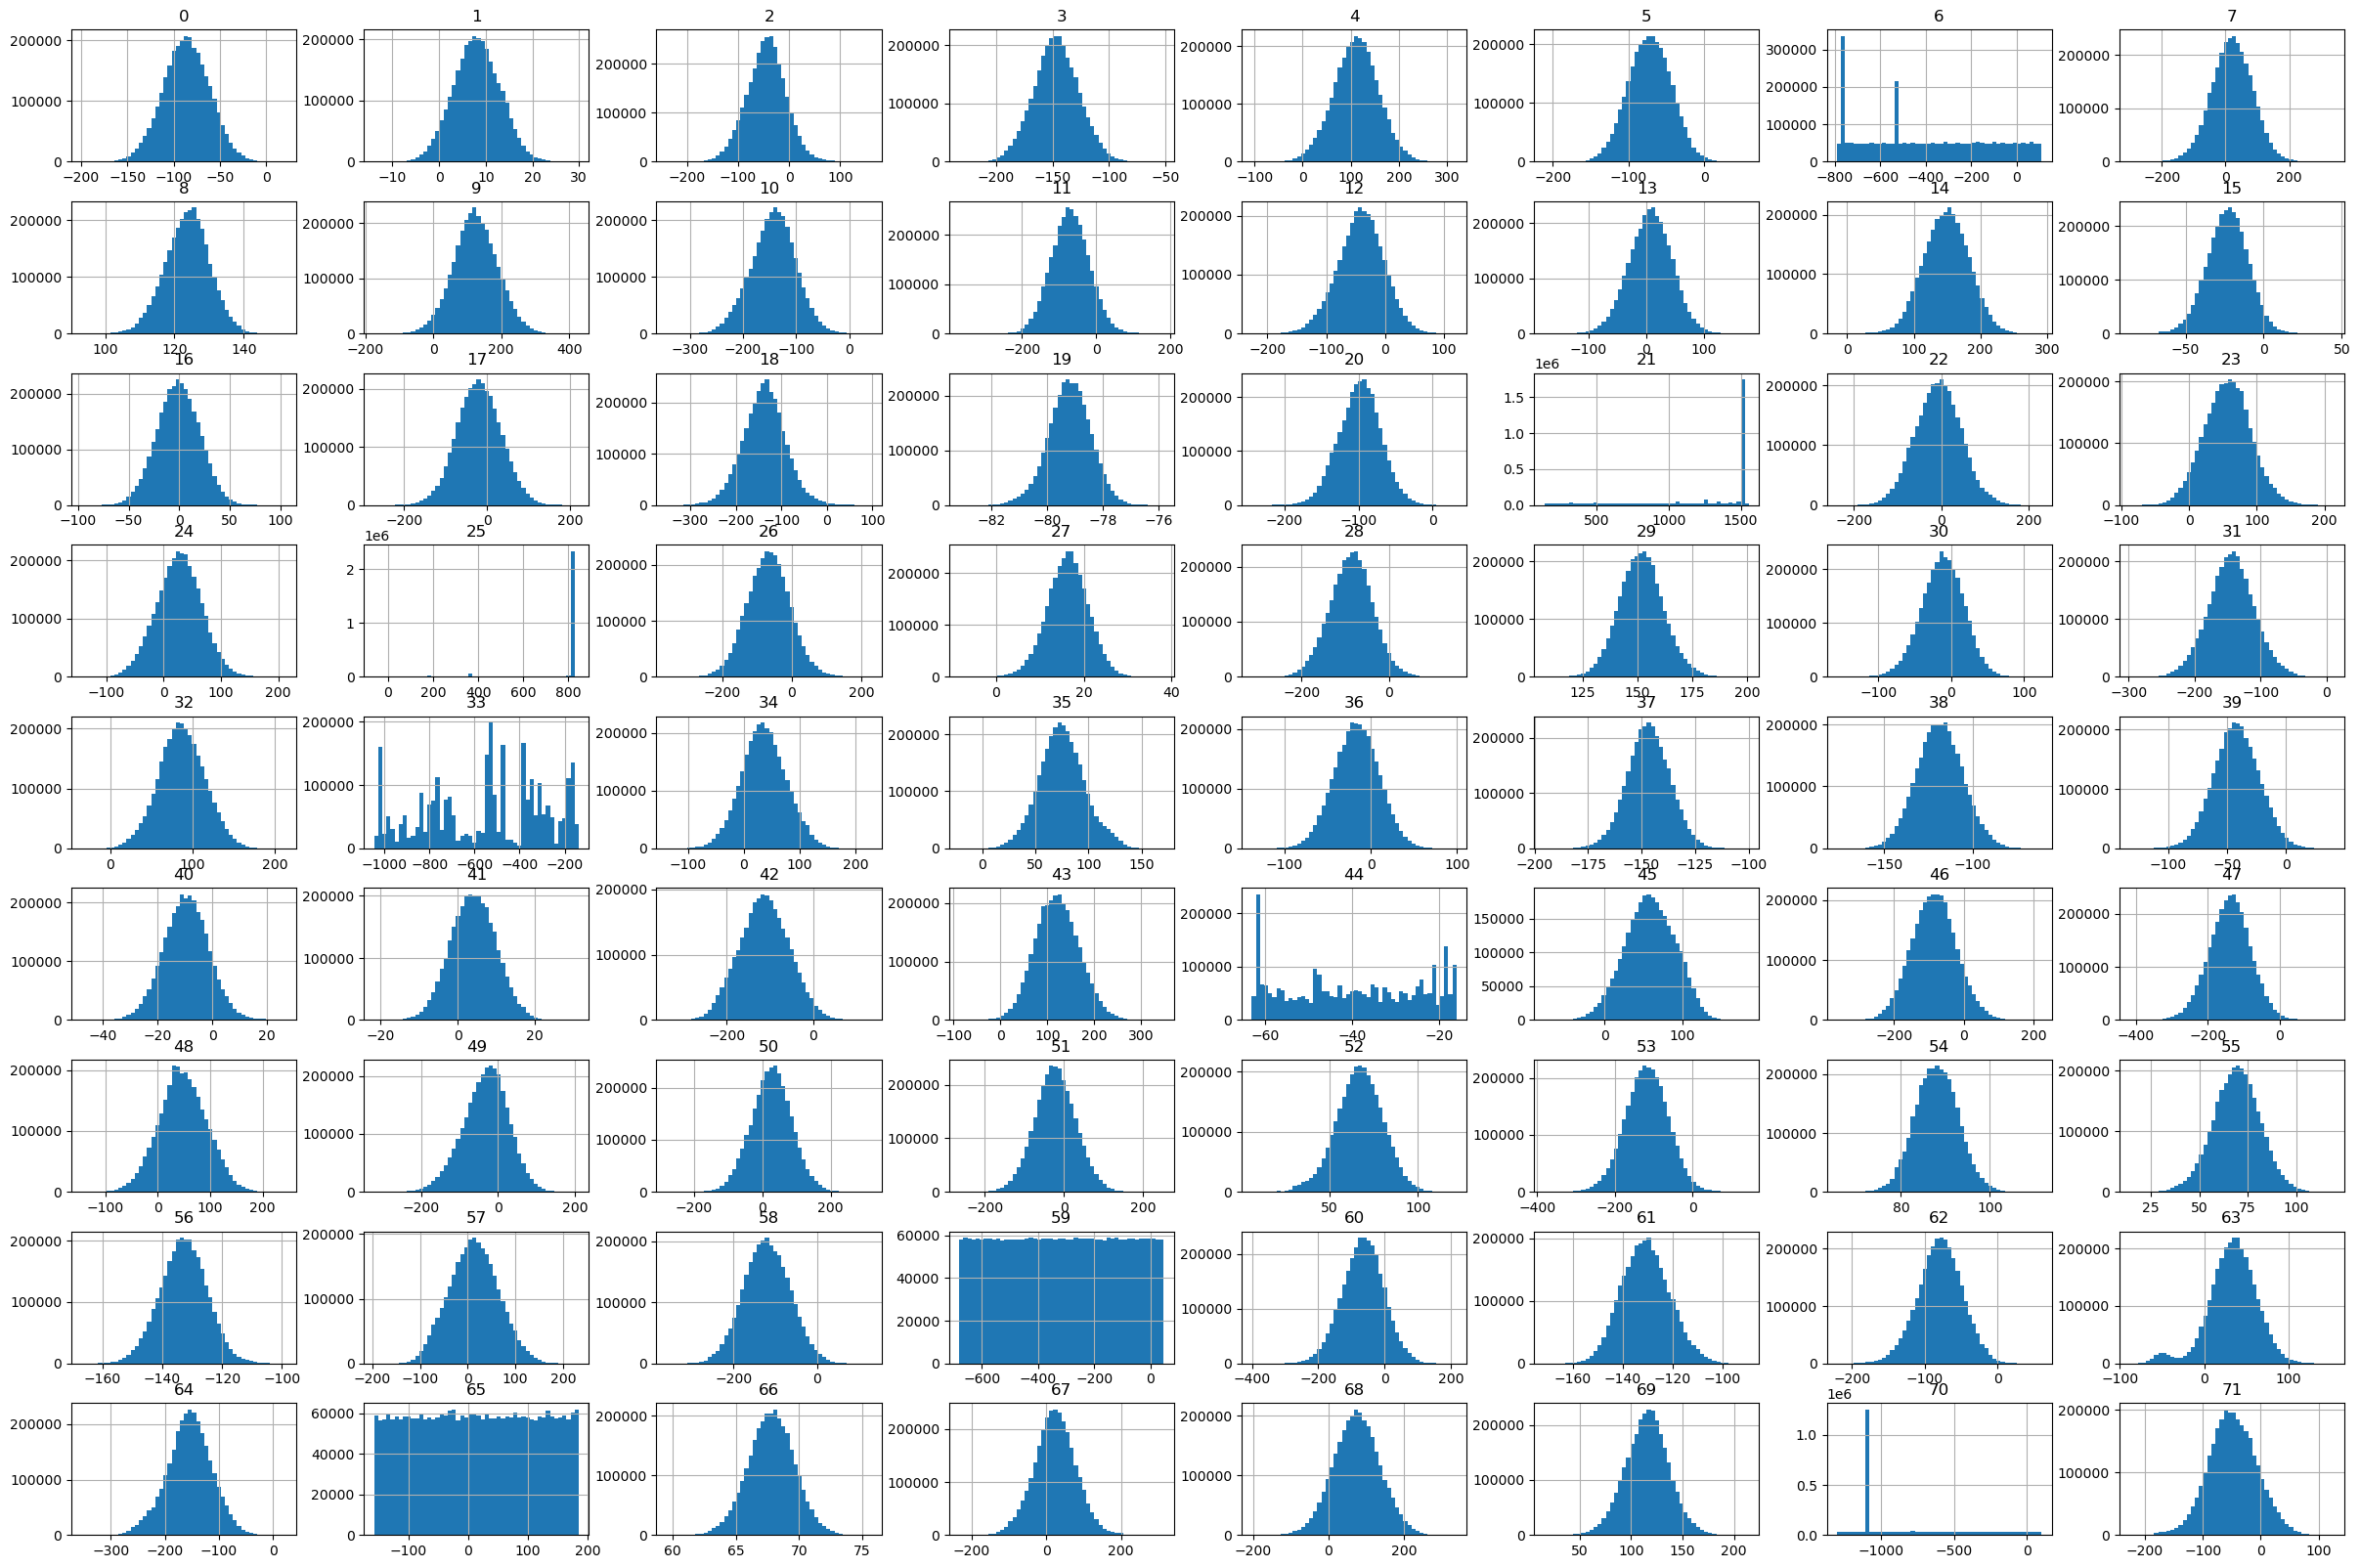

In [7]:
base.hist(figsize=[30,20], bins=50);

Посмотрим есть ли корреляции между признаками.

In [8]:
corr = base.corr()
corr.style.background_gradient(cmap='RdYlGn')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,-0.018697,0.027923,-0.018087,0.041373,-0.028934,0.003006,-0.005590,-0.000954,-0.006815,0.023097,0.010099,-0.022845,-0.023425,0.019311,-0.016958,-0.017863,-0.010239,0.011397,0.017781,0.037180,0.018493,0.027163,-0.044280,0.004687,0.045019,-0.009101,0.012514,-0.004652,0.002517,-0.042372,-0.043339,-0.002752,0.033086,0.002972,-0.029769,0.038084,0.008013,-0.005601,-0.008921,0.032631,-0.031545,0.023595,0.016180,0.001762,0.038761,-0.008306,0.023702,-0.040801,-0.002809,-0.000773,0.013148,0.046587,-0.018750,-0.016265,-0.019364,0.018162,0.063266,0.000227,0.000407,-0.012306,0.041890,-0.019047,0.040108,0.007845,0.003051,0.002094,0.027372,-0.008185,-0.019688,-0.021204,0.025474
1,-0.018697,1.000000,0.003489,0.009516,-0.020742,0.033579,0.011875,0.045928,0.004558,-0.036872,-0.073076,-0.032219,-0.013173,0.027931,-0.055133,0.062157,0.061852,-0.045343,0.008219,-0.025666,-0.054544,0.027760,-0.073152,0.017950,0.057634,0.002096,-0.012388,-0.009393,0.026895,-0.054487,0.050817,0.005163,-0.051761,0.026395,-0.026768,0.094630,-0.058088,-0.040804,-0.003273,0.002685,-0.037083,-0.038649,-0.046377,-0.028716,0.069395,0.034281,0.005295,0.017191,0.065112,0.014761,0.003738,-0.001708,-0.011019,0.028869,0.007554,0.024546,-0.044561,-0.096130,-0.014113,-0.000058,-0.031524,-0.035945,0.011564,-0.143105,0.009382,0.001380,0.055787,0.013307,-0.016829,0.030559,-0.017286,-0.015989
2,0.027923,0.003489,1.000000,-0.002529,0.004470,-0.053786,-0.001619,0.028222,0.002511,-0.001074,0.009154,-0.016238,-0.025841,0.021162,-0.010818,0.015326,0.025508,0.034773,0.002873,-0.006064,0.015603,0.040736,-0.040690,-0.030233,-0.013013,0.022908,-0.002307,0.006860,-0.006011,-0.027639,-0.008426,-0.019517,-0.009056,-0.015824,-0.036521,0.015467,-0.008119,-0.008318,0.011668,0.006016,-0.003798,-0.005573,0.007058,-0.020831,0.016626,0.023809,0.020972,-0.036845,0.043292,-0.027161,0.026049,-0.005029,0.039143,0.009673,0.015993,0.033355,0.005679,-0.009579,0.022710,-0.000767,-0.038005,-0.028917,-0.014118,0.017518,0.062886,0.001544,-0.027636,-0.000426,-0.037688,0.041420,0.009732,-0.042930
3,-0.018087,0.009516,-0.002529,1.000000,-0.007023,-0.002381,-0.000333,-0.001561,-0.014474,-0.011116,0.026432,-0.011853,-0.018399,-0.009245,0.020173,-0.002637,0.023142,0.011561,0.014114,0.003432,-0.002894,-0.037336,0.038242,-0.005994,0.008507,-0.014488,0.003505,-0.024557,0.036246,0.014288,0.028092,0.017625,0.025137,-0.010452,0.037633,-0.011120,0.025119,0.020288,-0.013526,-0.009155,0.033361,-0.003531,0.030520,0.020818,-0.004056,-0.011060,0.014299,-0.007456,-0.022798,0.020127,-0.014210,-0.004721,-0.050027,0.000613,-0.018196,0.012911,-0.034924,0.032016,-0.020457,0.000282,0.007735,-0.016073,-0.006192,0.021684,-0.003276,0.000453,-0.032467,-0.000672,0.023795,0.011546,-0.009644,-0.005703
4,0.041373,-0.020742,0.004470,-0.007023,1.000000,0.016437,0.002200,-0.014905,-0.003597,0.016579,0.015475,-0.029162,0.008319,0.017426,0.004866,-0.030409,-0.017512,-0.007001,0.001492,-0.012743,0.002689,-0.001216,0.001638,-0.021227,-0.007033,0.018734,-0.023956,-0.003821,-0.020626,-0.016300,0.000385,-0.037523,-0.028398,0.010687,-0.006619,-0.002860,0.021894,0.007947,0.019341,0.007524,0.005811,0.017841,0.002007,-0.020039,0.001624,0.001396,-0.019263,-0.023558,-0.009834,-0.028118,-0.056635,0.022511,0.005732,0.028982,0.007588,0.023967,-0.018694,-0.015901,0.011605,-0.000831,-0.005250,-0.019423,-0.012220,-0.005466,0.024066,0.006467,0.011873,0.023648,0.003213,-0.029733,-0.009048,0.042965
5,-0.028934,0.033579,-0.053786,-0.002381,0.016437,1.000000,-0.006725,0.000445,-0.015173,0.008102,-0.069388,-0.020909,0.004797,0.006058,-0.003478,0.079524,0.008555,-0.035042,0.028670,-0.039450,-0.038554,-0.045938,-0.050696,0.067238,-0.005886,0.001674,-0.016004,0.006129,-0.017443,-0.020337,0.021430,0.032980,-0.018834,0.015303,0.042484,0.066315,-0.081561,-0.003832,-

**Вывод:**

Мы написали функцию для загрузки данных, как полного датасета, так и мини версий. Провели исследовательский анализ данных. В данных пропусков нет.  Существенной корреляции между признаками не обнаружено.

На графиках распределения признаков видно, что некоторые признаки распределены не нормально, а равномерно. Обычно модели матчинга плохо работают с равномерным распределеним. Проверим эти признаки и удалим лишние для лучшей работы модели.

Поскольку модели будут делать выводы о близости объектов на основании расчёта растояний до них, необходимо промасштабировать данные, чтобы признаки, значения которых в миллион раз более высокие чем у других, не вопринимались моделью как более значимые.

#### Загрузка mini датасетов

In [9]:
base, train, validation, validation_answer = load_data(path, 'mini')

In [10]:
for i in [base, train, validation, validation_answer]:
    describe_data(i)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
6-base,-132.349780,12.640369,-80.635895,-137.11795,89.345490,-94.853520,-462.934000,91.356030,126.557274,147.39490,...,-55.650047,29.008305,-138.24612,156.300500,67.05420,-25.324776,85.734146,138.85352,-1070.5162,-2.041809
10-base,-98.898865,5.633918,-88.647285,-158.90100,87.810620,-76.610000,6.748629,-27.250978,126.672390,120.37991,...,-81.505670,19.662066,-125.73326,18.915530,67.41328,48.166084,146.343660,117.06042,-1152.3021,-73.153015
12-base,-68.859090,-0.939237,-47.824863,-153.82768,89.371060,-83.141740,-529.278500,39.693317,118.244225,140.70552,...,-58.820076,76.393720,-180.40990,85.385710,67.94069,-20.363410,162.172640,120.76160,-1092.4850,-64.907616
13-base,-71.780470,9.491869,-80.955360,-105.35263,84.318450,-78.632150,-429.259030,108.983040,124.514730,138.17792,...,-29.982979,40.114300,-138.04740,59.624220,68.61810,71.057980,95.904850,141.27716,-1205.3022,-51.975533
14-base,-121.066216,6.920069,-134.866850,-132.77559,19.703812,-37.102016,83.941820,-78.876540,125.779030,86.25271,...,-64.943320,56.583214,-239.40808,76.244835,64.53448,66.593765,109.980560,141.34575,-1074.4648,-156.521820


<class 'pandas.core.frame.DataFrame'>
Index: 583600 entries, 6-base to 4744763-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       583600 non-null  float64
 1   1       583600 non-null  float64
 2   2       583600 non-null  float64
 3   3       583600 non-null  float64
 4   4       583600 non-null  float64
 5   5       583600 non-null  float64
 6   6       583600 non-null  float64
 7   7       583600 non-null  float64
 8   8       583600 non-null  float64
 9   9       583600 non-null  float64
 10  10      583600 non-null  float64
 11  11      583600 non-null  float64
 12  12      583600 non-null  float64
 13  13      583600 non-null  float64
 14  14      583600 non-null  float64
 15  15      583600 non-null  float64
 16  16      583600 non-null  float64
 17  17      583600 non-null  float64
 18  18      583600 non-null  float64
 19  19      583600 non-null  float64
 20  20      583600 non-null  float64
 21  21  

None

Описание


<bound method NDFrame.describe of                        0          1           2          3           4  \
Id                                                                       
6-base       -132.349780  12.640369  -80.635895 -137.11795   89.345490   
10-base       -98.898865   5.633918  -88.647285 -158.90100   87.810620   
12-base       -68.859090  -0.939237  -47.824863 -153.82768   89.371060   
13-base       -71.780470   9.491869  -80.955360 -105.35263   84.318450   
14-base      -121.066216   6.920069 -134.866850 -132.77559   19.703812   
...                  ...        ...         ...        ...         ...   
4744645-base  -61.666348   2.128685  -81.667890 -153.11717   90.409004   
4744696-base  -73.158480  15.294069  -57.684612 -132.70872  110.756645   
4744759-base -108.598390   5.454173  -22.191975 -158.71666  113.606110   
4744762-base  -97.026730  -2.143885  -71.274090 -144.68066  149.464810   
4744763-base  -86.838430   8.911945  -34.837738 -106.46268   42.236572   

   

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
1-query,-87.77637,6.806268,-32.054546,-177.26039,120.80333,-83.810590,-94.57275,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.09220,-51.276833,366656-base
14-query,-107.74551,8.262278,1.303707,-122.30960,124.88633,-113.067260,-759.62604,-50.134230,125.86170,107.053070,...,19.192116,-169.01462,129.329820,69.071840,-21.853165,91.174060,86.220680,-951.97925,-119.347946,88328-base
17-query,-64.54115,6.379174,22.827354,-140.19008,118.12147,-45.949470,-167.82553,76.232230,116.56160,36.988052,...,68.939440,-232.42427,-151.365800,66.982070,21.464298,31.847046,125.621956,-1179.73110,-48.768707,1841709-base
21-query,-41.34329,12.988533,-52.500470,-177.08405,117.42550,-64.219170,-759.62604,119.854680,116.59877,28.824615,...,33.574203,-140.07430,-74.130066,70.309480,22.298388,53.082397,113.545525,-653.41100,8.083492,9331-base
24-query,-133.16289,-2.366189,-24.341312,-163.20690,136.80786,-64.591225,-759.62604,0.566725,121.06721,166.230510,...,21.065586,-151.60904,21.146963,71.008780,-37.431760,57.041412,141.719480,-1181.58060,-36.334442,915740-base


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1-query to 99995-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20000 non-null  float64
 1   1       20000 non-null  float64
 2   2       20000 non-null  float64
 3   3       20000 non-null  float64
 4   4       20000 non-null  float64
 5   5       20000 non-null  float64
 6   6       20000 non-null  float64
 7   7       20000 non-null  float64
 8   8       20000 non-null  float64
 9   9       20000 non-null  float64
 10  10      20000 non-null  float64
 11  11      20000 non-null  float64
 12  12      20000 non-null  float64
 13  13      20000 non-null  float64
 14  14      20000 non-null  float64
 15  15      20000 non-null  float64
 16  16      20000 non-null  float64
 17  17      20000 non-null  float64
 18  18      20000 non-null  float64
 19  19      20000 non-null  float64
 20  20      20000 non-null  float64
 21  21      20000 non-null  floa

None

Описание


<bound method NDFrame.describe of                       0          1           2          3           4  \
Id                                                                      
1-query      -87.776370   6.806268  -32.054546 -177.26039  120.803330   
14-query    -107.745510   8.262278    1.303707 -122.30960  124.886330   
17-query     -64.541150   6.379174   22.827354 -140.19008  118.121470   
21-query     -41.343290  12.988533  -52.500470 -177.08405  117.425500   
24-query    -133.162890  -2.366189  -24.341312 -163.20690  136.807860   
...                 ...        ...         ...        ...         ...   
99984-query  -90.368416  14.155788  -87.071260 -186.35990  -18.529205   
99989-query  -97.648476   9.691613 -103.170654 -134.14374  145.652220   
99990-query  -38.032570  11.494578  -19.129005 -152.18866  160.067350   
99991-query  -62.105550   9.067333  -37.834070 -168.25124  106.711586   
99995-query  -68.180530  11.657515  -63.179720 -188.72653  131.113100   

                

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100004-query,-79.53292,-0.364173,-16.027431,-170.88495,165.453920,-28.291668,33.931934,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.89230,-125.307890
100005-query,-89.74536,6.317698,-80.744650,-114.53197,153.960340,-74.897130,-208.928700,-32.214005,115.582855,61.603172,...,-64.934890,37.824436,-153.04173,-131.257920,68.26281,56.239280,120.64690,76.342550,-1156.99290,-72.146390
100007-query,-119.02685,7.536469,-62.973827,-142.94609,150.376110,-92.343550,-530.124700,24.280703,124.623260,119.622160,...,-121.699980,49.379295,-211.29207,37.299725,68.56667,21.038134,37.36427,116.667170,-1129.24290,-87.194520
100010-query,-57.71042,5.344710,-36.634872,-151.92635,123.258860,-82.446480,-530.124700,54.023262,118.234550,181.625780,...,-61.568954,35.105920,-134.64563,-7.372177,69.39937,16.125835,202.46930,120.868460,-195.12244,-121.981840
100013-query,-113.83982,5.682194,-7.384804,-142.80922,63.082832,-69.850624,-759.626040,31.846502,120.052260,121.982080,...,-60.315765,45.007620,-147.07414,34.577280,65.68382,251.287280,96.05116,110.661316,-560.48190,-13.711834


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 100004-query to 199997-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20000 non-null  float64
 1   1       20000 non-null  float64
 2   2       20000 non-null  float64
 3   3       20000 non-null  float64
 4   4       20000 non-null  float64
 5   5       20000 non-null  float64
 6   6       20000 non-null  float64
 7   7       20000 non-null  float64
 8   8       20000 non-null  float64
 9   9       20000 non-null  float64
 10  10      20000 non-null  float64
 11  11      20000 non-null  float64
 12  12      20000 non-null  float64
 13  13      20000 non-null  float64
 14  14      20000 non-null  float64
 15  15      20000 non-null  float64
 16  16      20000 non-null  float64
 17  17      20000 non-null  float64
 18  18      20000 non-null  float64
 19  19      20000 non-null  float64
 20  20      20000 non-null  float64
 21  21      20000 non-null

None

Описание


<bound method NDFrame.describe of                        0          1           2          3           4  \
Id                                                                       
100004-query  -79.532920  -0.364173  -16.027431 -170.88495  165.453920   
100005-query  -89.745360   6.317698  -80.744650 -114.53197  153.960340   
100007-query -119.026850   7.536469  -62.973827 -142.94609  150.376110   
100010-query  -57.710420   5.344710  -36.634872 -151.92635  123.258860   
100013-query -113.839820   5.682194   -7.384804 -142.80922   63.082832   
...                  ...        ...         ...        ...         ...   
199985-query -129.697630   5.962259 -100.910480 -156.47946  178.207900   
199986-query  -52.005882   2.728153  -15.433735 -153.53885  116.619530   
199990-query  -64.395600   7.386747  -42.248030 -138.83315  107.673060   
199994-query  -73.456550  10.805204  -28.588137 -163.68158   71.399506   
199997-query  -59.224453  13.585838   22.655106 -134.92603  145.205690   

   

,Expected
Id,
100004-query,75484-base
100005-query,1905037-base
100007-query,1533713-base
100010-query,641788-base
100013-query,11032-base


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 100004-query to 199997-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  20000 non-null  object
dtypes: object(1)
memory usage: 312.5+ KB


None

Описание


<bound method NDFrame.describe of                   Expected
Id                        
100004-query    75484-base
100005-query  1905037-base
100007-query  1533713-base
100010-query   641788-base
100013-query    11032-base
...                    ...
199985-query   252939-base
199986-query   112084-base
199990-query   364908-base
199994-query   148812-base
199997-query  1690782-base

[20000 rows x 1 columns]>

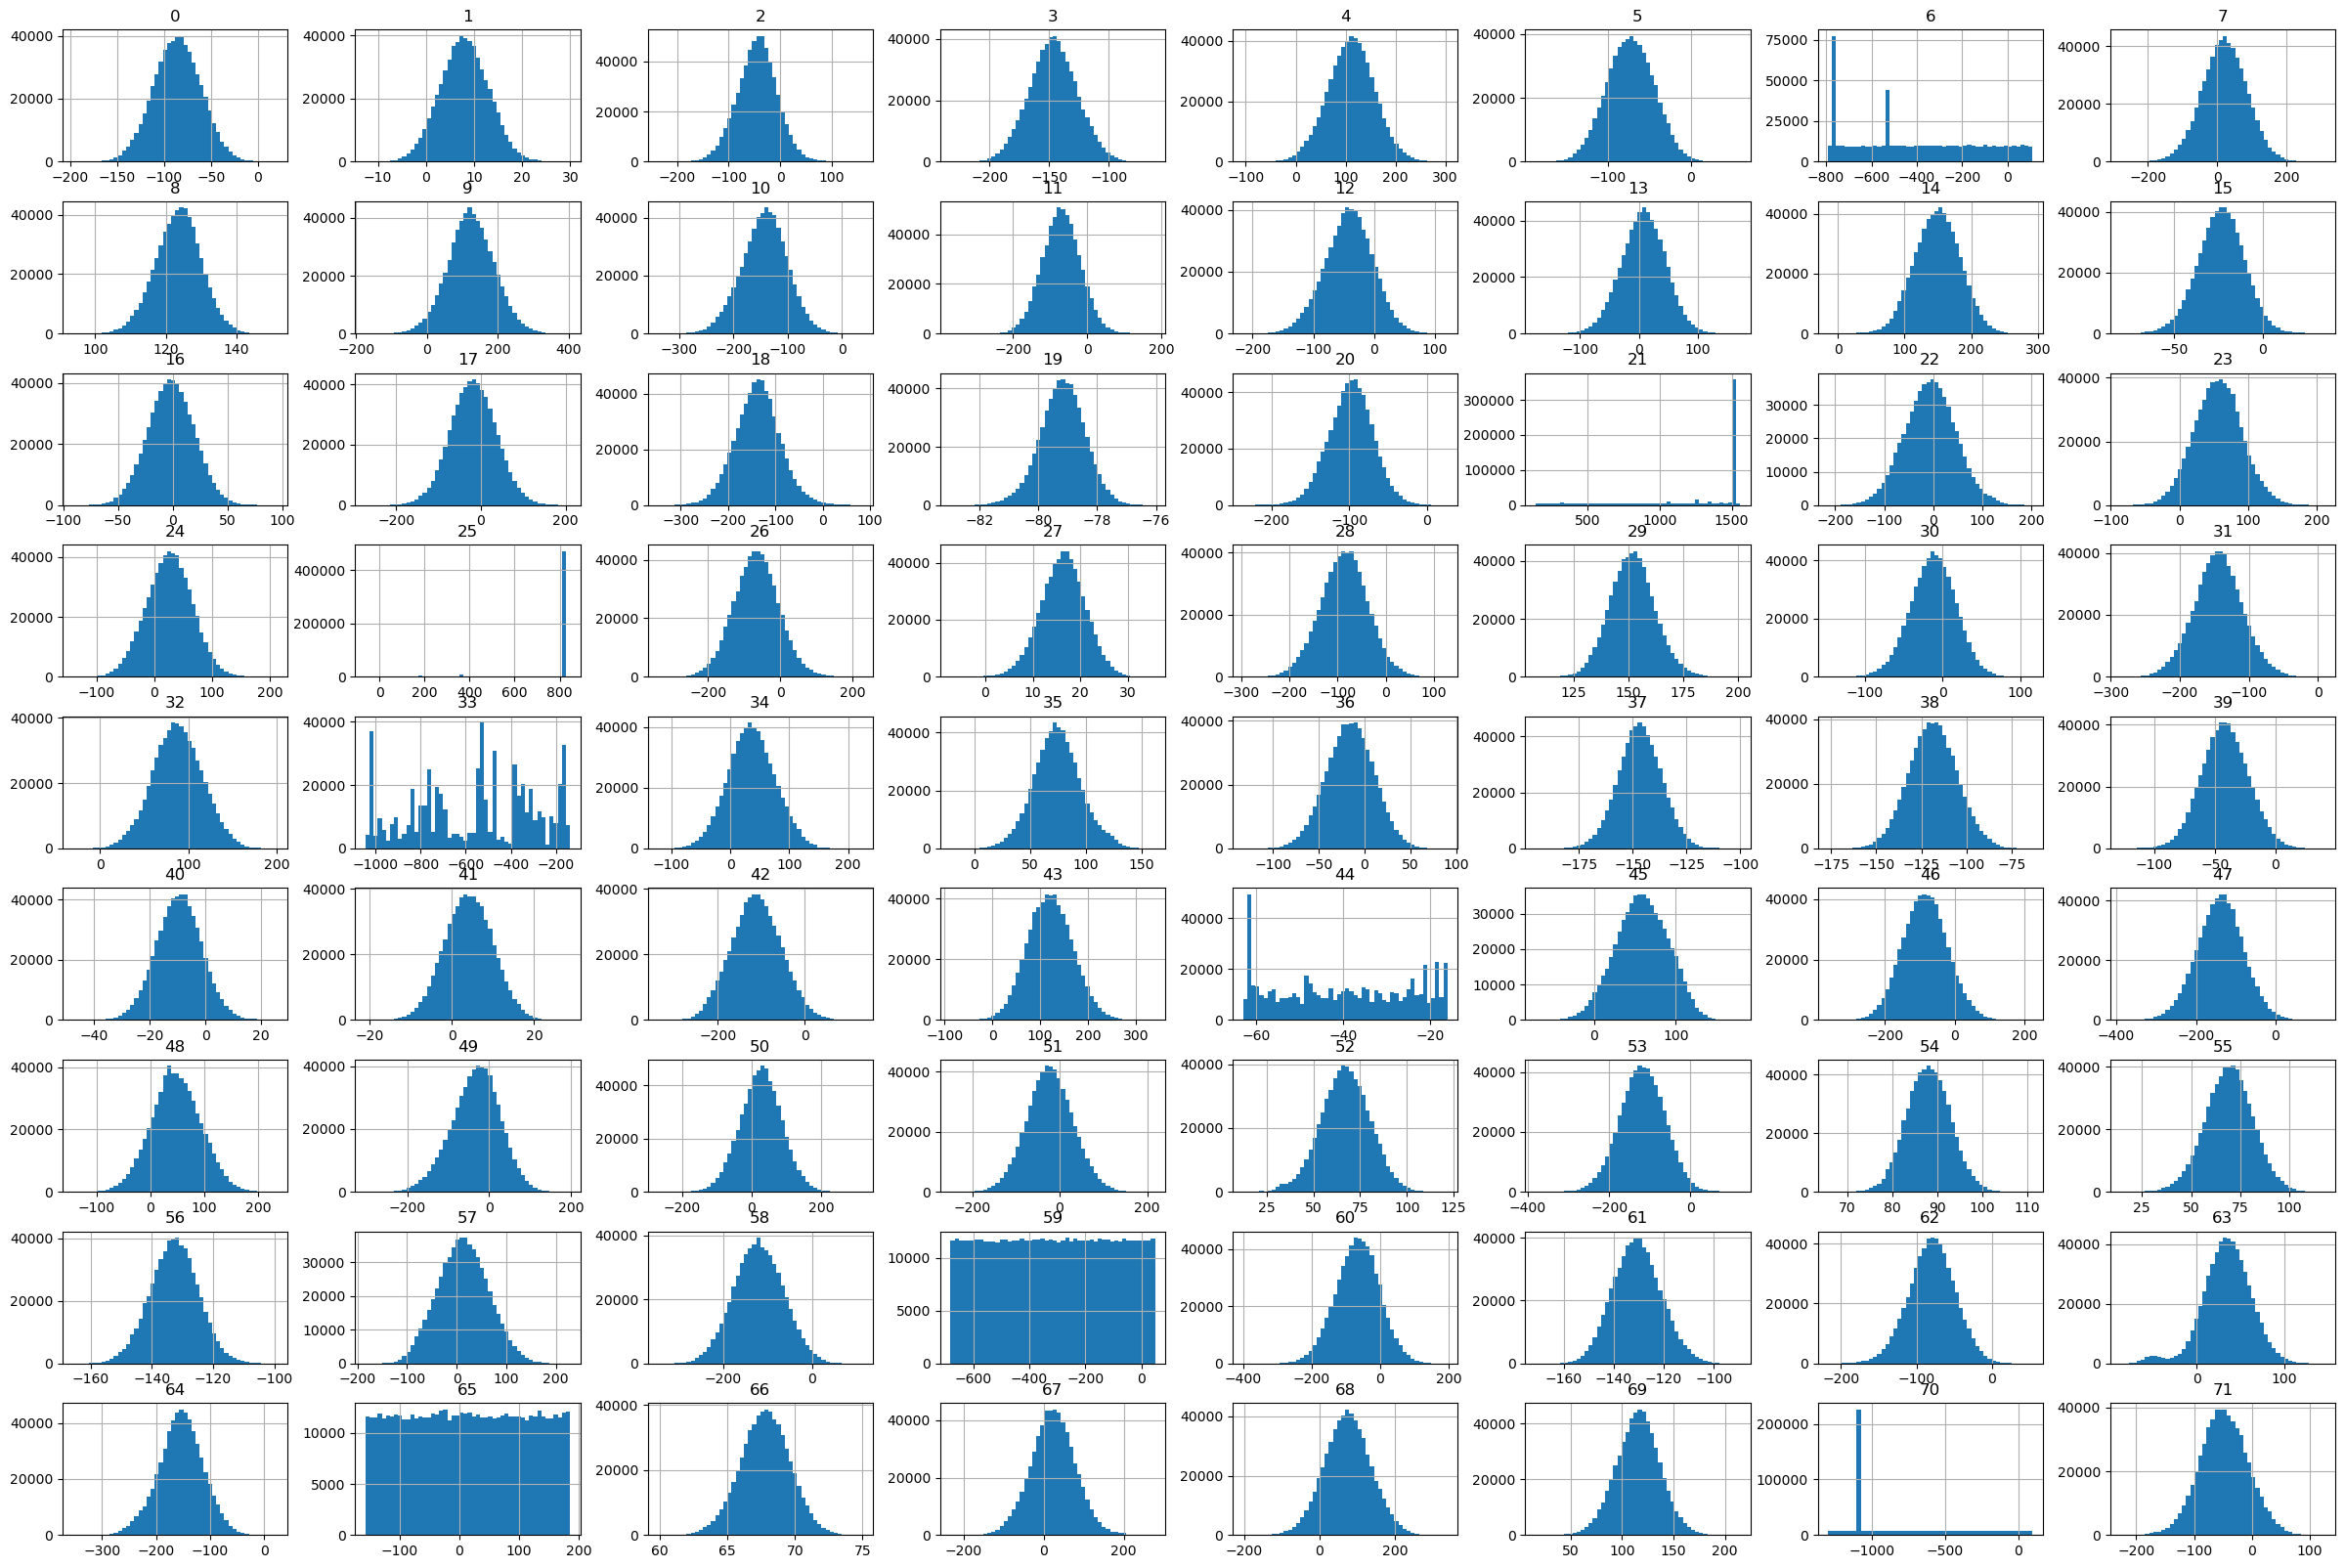

In [11]:
base.hist(figsize=[30,20], bins=50);

Посмотрим есть ли корреляции между признаками.

In [12]:
corr = base.corr()
corr.style.background_gradient(cmap='RdYlGn')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,-0.012669,0.021316,-0.016188,0.025368,-0.026208,0.004578,-0.008296,-0.002084,-0.007878,0.021407,0.007505,-0.017241,-0.015148,0.020373,-0.010854,-0.013806,-0.012298,0.012877,0.013924,0.031089,0.018279,0.022543,-0.042743,0.001681,0.039318,-0.009394,0.012526,0.005674,0.008448,-0.032142,-0.033479,-0.003085,0.031682,0.006928,-0.020774,0.025183,0.003342,0.005342,-0.001905,0.023334,-0.028399,0.015956,0.013622,0.007701,0.035942,-0.005012,0.024360,-0.030922,0.000212,-0.001968,0.009850,0.030667,-0.021416,-0.013534,-0.010385,0.019970,0.043690,0.003047,0.001663,0.000402,0.032890,-0.013901,0.025248,0.001468,0.003439,-0.002587,0.022641,-0.007056,-0.019572,-0.016943,0.015844
1,-0.012669,1.000000,0.001104,0.009387,-0.018081,0.024579,0.014322,0.036059,0.004355,-0.027750,-0.052608,-0.022298,-0.009606,0.028547,-0.041758,0.044657,0.049077,-0.031320,0.004228,-0.015472,-0.032481,0.017816,-0.058880,0.016970,0.049492,0.002136,-0.008418,-0.005974,0.015125,-0.034392,0.043111,0.007895,-0.036303,0.027304,-0.023574,0.073047,-0.038706,-0.026478,-0.001750,0.007691,-0.029295,-0.026464,-0.042464,-0.022631,0.062341,0.026725,0.002555,0.006568,0.043776,0.006180,-0.000940,0.001293,-0.009389,0.021228,0.004584,0.019621,-0.035586,-0.068795,-0.013306,-0.002074,-0.031482,-0.030557,0.006218,-0.114549,0.001347,0.000549,0.042301,0.008287,-0.012111,0.024996,-0.020966,-0.006977
2,0.021316,0.001104,1.000000,-0.004408,0.000832,-0.037384,-0.004198,0.016398,0.008122,0.004019,0.002100,-0.013163,-0.019118,0.012519,-0.009488,0.008222,0.021683,0.019327,-0.000395,-0.012773,0.004972,0.035175,-0.033366,-0.022705,-0.015024,0.019399,-0.001637,0.001791,0.002607,-0.017168,-0.003099,-0.013977,-0.006859,-0.006315,-0.028458,0.014260,-0.009744,-0.010042,0.012439,-0.003514,-0.007547,-0.005334,0.003108,-0.014082,0.020100,0.012144,0.015495,-0.027203,0.035568,-0.021422,0.023432,-0.002537,0.022644,0.008267,0.010543,0.026657,0.005948,-0.009131,0.019115,-0.004442,-0.035916,-0.024564,-0.017615,0.011998,0.045296,0.001690,-0.029140,-0.003083,-0.034896,0.033823,0.010098,-0.031157
3,-0.016188,0.009387,-0.004408,1.000000,-0.000599,-0.000836,-0.003044,-0.001312,-0.013041,0.000587,0.020136,-0.009541,-0.012767,-0.005782,0.008723,-0.001892,0.014750,0.008606,0.017540,-0.000418,0.002569,-0.032106,0.036952,-0.008262,0.007826,-0.013365,0.006716,-0.015977,0.026132,0.008880,0.020379,0.014374,0.025453,-0.009467,0.024517,-0.009701,0.016326,0.016653,-0.009415,-0.008239,0.028883,0.001265,0.022146,0.011321,-0.005310,-0.002778,0.007654,-0.002732,-0.017400,0.011913,-0.010829,-0.006403,-0.034683,0.008492,-0.008253,0.006468,-0.028676,0.027572,-0.015645,0.000625,0.013001,-0.010370,-0.005413,0.010691,-0.004441,-0.001275,-0.019349,0.002772,0.024444,0.006425,-0.005805,0.000443
4,0.025368,-0.018081,0.000832,-0.000599,1.000000,0.011397,0.007562,-0.012201,-0.007266,0.016472,0.009178,-0.024137,0.005275,0.022668,0.000212,-0.028990,-0.016773,-0.005622,0.008403,-0.015990,0.003256,-0.003612,0.003178,-0.012161,-0.004245,0.019568,-0.015040,-0.004138,-0.009127,-0.010575,-0.002017,-0.026363,-0.020317,0.009014,-0.006015,-0.008020,0.026516,0.010651,0.017299,0.015289,0.009373,0.012747,-0.001568,-0.013615,0.007040,0.008921,-0.021859,-0.026342,-0.007886,-0.023131,-0.048298,0.013709,-0.008616,0.022591,0.007536,0.011488,-0.016153,-0.011780,0.011459,-0.001485,-0.006469,-0.010591,-0.005518,-0.001859,0.017128,0.006203,0.010210,0.015535,0.002037,-0.023219,-0.009685,0.029363
5,-0.026208,0.024579,-0.037384,-0.000836,0.011397,1.000000,-0.012474,0.000282,-0.017148,0.012698,-0.057972,-0.019798,-0.000877,0.005612,-0.000045,0.065257,0.008596,-0.028371,0.026114,-0.034864,-0.031681,-0.045501,-0.035958,0.053272,-0.002487,-0.003044,-0.009208,0.006541,-0.018061,-0.023662,0.018646,0.020550,-0.016218,0.008009,0.027152,0.050082,-0.067661,-0.001454,-0

**Вывод:**

Также как и в основных данных, в мини датасетах пропусков нет.  Существенной корреляции между признаками не обнаружено.

## Подготовка данных

Подготовим данные для обучения модели. Выделим целевой признак.

In [13]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

### Масштабирование данных

Промасштабируем данные.

In [14]:
%%time
scaler = StandardScaler()
scaler.fit(base[base.columns])
base[base.columns] = scaler.transform(base[base.columns])
train[base.columns] = scaler.transform(train[base.columns])
validation[base.columns] = scaler.transform(validation[base.columns])

CPU times: total: 734 ms
Wall time: 723 ms


In [15]:
base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
6-base,-1.844302,0.938935,-0.935685,0.470897,-0.471968,-0.791536,-0.229745,1.091887,0.470482,0.353140,...,0.780331,-0.185034,0.389197,1.439554,-0.404188,-0.881574,0.179773,1.097205,-0.744123,1.104306
10-base,-0.512724,-0.472419,-1.142422,-0.618423,-0.504862,-0.148039,1.488932,-0.737130,0.488479,-0.065007,...,-0.065770,-0.517234,0.693104,0.050318,-0.207510,0.445020,1.165007,0.072254,-0.952773,-0.604202
12-base,0.683067,-1.796492,-0.088984,-0.364718,-0.471420,-0.378431,-0.472515,0.295206,-0.829206,0.249600,...,0.676595,1.499223,-0.634862,0.722464,0.081367,-0.792016,1.422314,0.246324,-0.800170,-0.406099
13-base,0.566776,0.304712,-0.943929,2.059408,-0.579702,-0.219366,-0.106520,1.363710,0.151144,0.210476,...,1.620261,0.209715,0.394023,0.461964,0.452403,0.858245,0.345102,1.211191,-1.087986,-0.095395
14-base,-1.395138,-0.213342,-2.335134,0.688049,-1.964457,1.245510,1.771400,-1.533239,0.348809,-0.593239,...,0.476217,0.795083,-2.067789,0.630032,-1.784309,0.777661,0.573909,1.214417,-0.754197,-2.607210


### Удаление лишних признаков

Напишем цикл, который проверяет отрицательно или положительно влияет каждый признак на метрику модели. В качестве модели выбирем NearestNeighbors. На небольшом наборе данных она работает достаточно быстро.

In [16]:
neigh = NearestNeighbors(n_neighbors=5, algorithm = 'auto', n_jobs = -1)

In [17]:
%%time
# Определим значение метрики, если модель работает со всеми признаками
neigh.fit(base)
distances, indices = neigh.kneighbors(train)

base_index = {k: v for k, v in enumerate(base.index.to_list())}

acc = 0
for target, el in zip(targets.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[r] for r in el])
acc_base = 100 * acc / len(indices)
print(acc_base, "%")

72.44 %
CPU times: total: 1min 46s
Wall time: 14.1 s


In [18]:
%%time
# Исключим по очереди все признаки, и, если метрика без како-го признака улучшится,
# добавим этот признак список "на удаление."
col_to_drop = []

for col in base.columns:
    base_sample = base.drop(columns = col, axis = 1)
    train_sample = train.drop(columns = col, axis = 1)
    base_index = {k: v for k, v in enumerate(base_sample.index.to_list())}
    
    neigh.fit(base_sample)
    distances, indices = neigh.kneighbors(train_sample)
    
    acc = 0
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_index[r] for r in el])
        acc_new = 100 * acc / len(indices)

    if acc_new > acc_base:
        col_to_drop.append(col)
        print(col, acc_new, "%")

8 72.445 %
21 73.085 %
25 73.05 %
33 74.1 %
44 72.505 %
59 72.845 %
65 72.875 %
CPU times: total: 2h 9min 28s
Wall time: 17min 9s


In [19]:
# Список признаков на удаление
col_to_drop

['8', '21', '25', '33', '44', '59', '65']

In [20]:
# Напишем функцию для удаления признаков
def drop_features_list(df_list, col_list):
    for data in df_list:
        print("Количество признаков в", data, "до", globals()[data].shape[1])
        globals()[data] = globals()[data].drop(columns = col_list, axis = 1)
        print("Количество признаков в", data, "после", globals()[data].shape[1], '\n')

In [21]:
df_list = ['base', 'train', 'validation']
drop_features_list(df_list, col_to_drop)

Количество признаков в base до 72
Количество признаков в base после 65 

Количество признаков в train до 72
Количество признаков в train после 65 

Количество признаков в validation до 72
Количество признаков в validation после 65 



**Вывод**

Мы создали простую модель NearestNeighbors. Мы по очереди исключали каждый признак, и, если метрика без него улучшалась, удаляли этот признак.

## NearestNeighbors

Для начала, попробуем решить задачу матчинга с помощью NearestNeighbors. Запомним метрику, а также время работы модели для последующего сравнения.

In [22]:
%%time
start_time = time.time()

neigh = NearestNeighbors(n_neighbors=5, algorithm = 'auto', n_jobs = -1)
neigh.fit(base)

end_time = time.time()  # время окончания выполнения
learn_time_neigh = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {learn_time_neigh} секунд")

Время выполнения программы: 0.19104242324829102 секунд
CPU times: total: 188 ms
Wall time: 191 ms


In [23]:
start_time = time.time()  # время начала выполнения

distances, indices = neigh.kneighbors(train)


end_time = time.time()  # время окончания выполнения
ex_time_neigh = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_neigh} секунд")

Время выполнения программы: 13.479028463363647 секунд


In [24]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [25]:
acc = 0
for target, el in zip(targets.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[r] for r in el])

acc_neigh = 100 * acc / len(indices)
print(acc_neigh, "%")

76.525 %


**Вывод**

На кросс-валидации модель показала достатчно высокую метрику accuracy 76.525 % и неплохое время - 13.5 сек.

## Faiss

Попробуем решить задачу при помощи библиотеки Faiss.

Подготовим векторы признаков для работы с ней.

In [26]:
vectors = np.ascontiguousarray(base.values).astype('float32')
vectors

array([[-1.8443022 ,  0.93893456, -0.935685  , ...,  1.0972053 ,
        -0.74412334,  1.1043065 ],
       [-0.51272416, -0.4724193 , -1.1424218 , ...,  0.07225417,
        -0.9527734 , -0.6042021 ],
       [ 0.68306684, -1.7964917 , -0.08898446, ...,  0.24632435,
        -0.8001696 , -0.4060992 ],
       ...,
       [-0.89883244, -0.5086265 ,  0.5724815 , ..., -1.0343795 ,
        -0.7541969 , -1.0281959 ],
       [-0.43820024, -2.0391517 , -0.69410026, ...,  0.65902364,
        -0.7541969 ,  1.266724  ],
       [-0.03263538,  0.18789445,  0.246153  , ...,  0.43827665,
        -0.7541969 , -0.18702407]], dtype=float32)

In [27]:
query = np.ascontiguousarray(train.values).astype('float32')
query

array([[-0.06997188, -0.23626551,  0.31797427, ...,  0.70854634,
        -0.65375054, -0.0786078 ],
       [-0.8648819 ,  0.0570279 ,  1.178796  , ..., -1.3781694 ,
        -0.44171497, -1.7140754 ],
       [ 0.8549507 , -0.32229775,  1.7342216 , ...,  0.47491172,
        -1.0227495 , -0.01834789],
       ...,
       [ 1.9101757 ,  0.7081306 ,  0.6515225 , ..., -1.0136383 ,
         1.9845161 , -0.6216205 ],
       [ 0.9519045 ,  0.21919523,  0.16883157, ..., -0.260151  ,
        -1.1758906 , -0.2547296 ],
       [ 0.7100782 ,  0.740952  , -0.4852221 , ..., -0.39911252,
        -0.7541969 ,  0.30937594]], dtype=float32)

### IndexFlatL2

Начнём с 'flat' индексов, которые не модифицируют вектора.

In [28]:
dim = base.shape[1]
index = faiss.IndexFlatL2(dim) 

In [29]:
%%time
start_time = time.time()

print(index.is_trained)
index.add(vectors)
print(index.ntotal)

end_time = time.time()  # время окончания выполнения
learn_time_IndexFlatL2 = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {learn_time_IndexFlatL2} секунд")

True
583600
Время выполнения программы: 0.03200697898864746 секунд
CPU times: total: 31.2 ms
Wall time: 32 ms


In [30]:
%%time
start_time = time.time()  # время начала выполнения

k = 5
D, I = index.search(query, k)

end_time = time.time()  # время окончания выполнения
ex_time_IndexFlatL2 = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_IndexFlatL2} секунд")

Время выполнения программы: 615.122533082962 секунд
CPU times: total: 1h 27min 48s
Wall time: 10min 15s


In [31]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [32]:
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[i] for i in el])

acc_IndexFlatL2 = 100 * acc / len(I)
print(acc_IndexFlatL2, "%")

76.525 %


**Вывод**

Поскольку данные типы индексов не используют кластеризацию, они выдают довольно высокое качество матчинга, ондако при большом объёме данные работают очень медленно.

IndexFlatIP показал худшие результаты и по точности, и по времени. Метрика accuracy составила 76.525 %, при времени 615 секунд.

### HNSW index

Попробуем другой тип индекса.

In [33]:
start_time = time.time()
# set HNSW index parameters
M = 64 #64  # number of connections each vertex will have
ef_search = 96  # depth of layers explored during search
ef_construction = 64  # depth of layers explored during index construction
dim = base.shape[1]
# initialize index
index = faiss.IndexHNSWFlat(dim, M)
# set efConstruction and efSearch parameters
index.hnsw.efConstruction = ef_construction
index.hnsw.efSearch = ef_search
# add data to index
index.add(vectors)

end_time = time.time()  # время окончания выполнения
learn_time_HNSW = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {learn_time_HNSW} секунд")

Время выполнения программы: 49.47770142555237 секунд


In [34]:
start_time = time.time()  # время начала выполнения

index.nprobe = 40  # Проходим по топ-16 центроид для поиска top-n ближайших соседей

D, I = index.search(query, 5)

end_time = time.time()  # время окончания выполнения
ex_time_HNSW = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_HNSW} секунд")

Время выполнения программы: 1.154266357421875 секунд


In [35]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [36]:
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[B] for B in el])

acc_HNSW = 100 * acc / len(I)
print(acc_HNSW, "%")

75.88 %


**Вывод**

HNSW index показывает хорошую метрику и очень короткое время. Однако при обработке большого датасета потребует больших затрат памяти. Метрика accuracy составила 75.885 %, а время 1.15 секунд.

### IndexIVFFlat

Перейдём к IndexIVFFlat.

Попробуем подобрать лучшие параметры для разделения на кластеры nlist и количества кластеров, в которых будет производится поиск nprobe.

In [37]:
dim = base.shape[1]
quantizer = faiss.IndexFlatL2(dim) 
#quantiser = faiss.IndexFlatIP(dim)

base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [38]:
%%time

nlist_list = []
nprobe_list = []
acc_list = []
time_list = []

for nlist_s in [100, 500, 1000]:
    nlist = nlist_s
    index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_L2) #METRIC_INNER_PRODUCT
    index.train(vectors)
    index.add(vectors)
    

    for nprobe_s in [5, 10, 40]:
        index.nprobe = nprobe_s       
        start_time = time.time()
        D, I = index.search(query, 5) 
        end_time = time.time()  # время окончания выполнения
        ex_time = round(end_time - start_time, 3) # вычисляем время выполнения
        
        acc = 0
        for target, el in zip(targets.values.tolist(), I.tolist()):
            acc += int(target in [base_index[B] for B in el])
        
        nlist_list.append(nlist_s)
        nprobe_list.append(nprobe_s)
        acc_list.append(100 * acc / len(I))
        time_list.append(ex_time)
    
        
        
        print(nlist_s, nprobe_s, 100 * acc / len(I), ex_time)
        
        #print(f"Время выполнения программы: {ex_time_IndexIVFFlat} секунд")

100 5 74.685 4.586
100 10 75.54 8.811
100 40 76.29 37.927
500 5 73.515 0.973
500 10 74.705 1.733
500 40 75.71 5.532
1000 5 72.935 0.614
1000 10 74.43 0.997
1000 40 75.51 2.988
CPU times: total: 56min 22s
Wall time: 5min 5s


In [39]:
#convert lists into a single list
data = []
data.append(nlist_list)
data.append(nprobe_list)
data.append(acc_list)
data.append(time_list)


#convert list into DataFrame
df = pd.DataFrame(data).transpose()
df.columns =['nlist', 'nprobe', 'acc', 'time']

#view resulting DataFrame
df

,nlist,nprobe,acc,time
0,100.0,5.0,74.685,4.586
1,100.0,10.0,75.540,8.811
2,100.0,40.0,76.290,37.927
3,500.0,5.0,73.515,0.973
4,500.0,10.0,74.705,1.733
5,500.0,40.0,75.710,5.532
6,1000.0,5.0,72.935,0.614
7,1000.0,10.0,74.430,0.997
8,1000.0,40.0,75.510,2.988


In [40]:
dim = base.shape[1] #how many partitions we’d like our index to have
nlist = 500 # количество кластеров 141
quantizer = faiss.IndexFlatL2(dim) 
#quantiser = faiss.IndexFlatIP(dim)
index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_L2) #METRIC_INNER_PRODUCT

In [41]:
%%time

start_time = time.time()

#Запускаем обучение:
print(index.is_trained)   # False.
index.train(vectors)  # Train на нашем наборе векторов
 
# Обучение завершено, но векторов в индексе пока нет, так что добавляем их в индекс:
print(index.is_trained)  # True
print(index.ntotal)   # 0
index.add(vectors)
print(index.ntotal)   # 1000000

end_time = time.time()  # время окончания выполнения
learn_time_IndexIVFFlat = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {learn_time_IndexIVFFlat} секунд")

False
True
0
583600
Время выполнения программы: 64.34783029556274 секунд
CPU times: total: 13min 26s
Wall time: 1min 4s


In [42]:
start_time = time.time()  # время начала выполнения

index.nprobe = 40 #int(math.sqrt(base_mini.shape[0]))  # Проходим по топ-16 центроид для поиска top-n ближайших соседей
D, I = index.search(query, 5) 

end_time = time.time()  # время окончания выполнения
ex_time_IndexIVFFlat = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_IndexIVFFlat} секунд")

Время выполнения программы: 5.5662522315979 секунд


In [43]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [44]:
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[B] for B in el])

acc_IndexIVFFlat_L2 = 100 * acc / len(I)
print(acc_IndexIVFFlat_L2, "%")

75.71 %


**Вывод**

При использовании IndexIVFFlat, лучший результат показала модель с наименьших количеством кластеров - 100, и наибольшим количеством nprobe - 40. Метрика accuracy составила 76.290%. Однако она же наиболее затратна по времени - 37.927 секунд. Стоит выбрать модель с количеством кластеров - 500, и количеством nprobe - 40, так как её метрика очень близка к лучшей, а времени она затричивает гораздо меньше: accuracy = 75.710%, время -	5.532 секунд.

## Итог

In [45]:
final_data = pd.DataFrame({'Модель' : ['NearestNeighbors', 'IndexFlatL2', 'IndexIVFFlat_METRIC_L2', 'HNSW',],
                          'Accuracy_5' : [acc_neigh, acc_IndexFlatL2, acc_IndexIVFFlat_L2, acc_HNSW],
                          'Время_обучения' : [learn_time_neigh, learn_time_IndexFlatL2, learn_time_IndexIVFFlat, learn_time_HNSW],
                          'Время_выполнения' : [ex_time_neigh, ex_time_IndexFlatL2, ex_time_IndexIVFFlat, ex_time_HNSW]})

final_data['Общее_время'] = final_data['Время_обучения'] + final_data['Время_выполнения']
final_data

,Модель,Accuracy_5,Время_обучения,Время_выполнения,Общее_время
0,NearestNeighbors,76.525,0.191042,13.479028,13.670071
1,IndexFlatL2,76.525,0.032007,615.122533,615.154540
2,IndexIVFFlat_METRIC_L2,75.710,64.347830,5.566252,69.914083
3,HNSW,75.880,49.477701,1.154266,50.631968


**Вывод**

По итогам тестирования лучшие результаты точности показали модели NearestNeighbors и faiss с индексом IndexFlatL2. Метрика accuracy составила 76.525%.  Однако NearestNeighbors существенно выигрывает по времени. Общее время выполнения программы 13.67 сек. против 615.15 сек. у IndexFlatL2.

## Full dataset

Перейдём к работе на всём датасете. Загрузим данные и проведём предобработку.

In [46]:
base, train, validation, validation_answer = load_data(path, 'full')

In [47]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

In [48]:
df_list = ['base', 'train', 'validation']
drop_features_list(df_list, col_to_drop)

Количество признаков в base до 72
Количество признаков в base после 65 

Количество признаков в train до 72
Количество признаков в train после 65 

Количество признаков в validation до 72
Количество признаков в validation после 65 



In [49]:
%%time
scaler = StandardScaler()
scaler.fit(base[base.columns])
base[base.columns] = scaler.transform(base[base.columns])
train[base.columns] = scaler.transform(train[base.columns])
validation[base.columns] = scaler.transform(validation[base.columns])

CPU times: total: 3.33 s
Wall time: 3.34 s


In [50]:
%%time
targets_valid = validation_answer['Expected']

CPU times: total: 0 ns
Wall time: 1 ms


### NearestNeighbors full dataset

In [51]:
%%time

neigh = NearestNeighbors(n_neighbors=5, algorithm = 'auto', n_jobs = -1)
neigh.fit(base)

CPU times: total: 984 ms
Wall time: 972 ms


NearestNeighbors(n_jobs=-1)

In [52]:
%%time
start_time = time.time()  # время начала выполнения

distances, indices = neigh.kneighbors(train)


end_time = time.time()  # время окончания выполнения
ex_time_neigh_full = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_neigh_full} секунд")

Время выполнения программы: 324.6483745574951 секунд
CPU times: total: 42min 49s
Wall time: 5min 24s


In [53]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [54]:
acc = 0
for target, el in zip(targets.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[r] for r in el])

acc_neigh_full = 100 * acc / len(indices)
print(acc_neigh_full, "%")

71.933 %


#### Validation

In [55]:
targets_valid = validation_answer['Expected']

In [56]:
%%time
distances, indices = neigh.kneighbors(validation)

CPU times: total: 45min 2s
Wall time: 5min 41s


In [57]:
acc = 0
for target, el in zip(targets_valid.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[B] for B in el])

print(100 * acc / len(indices))

71.816


**Вывод**

Мы создали модель NearestNeighbors. На полном датасете, аccuracy на кросс-валидации составила 71.933 %. А на тестовой выборке - 71.816%. При этом на получение результатов ушло всего около 5 минут.

### Faiss full dataset

In [58]:
%%time
vectors = np.ascontiguousarray(base.values).astype('float32')
vectors

CPU times: total: 1.12 s
Wall time: 1.12 s


array([[-1.1592162 ,  0.6203504 , -0.51372266, ..., -0.0140507 ,
         1.7814198 , -0.3123287 ],
       [ 2.0757148 ,  1.0604233 , -0.652491  , ...,  0.05984761,
         1.8537259 , -0.2810519 ],
       [ 1.2854173 , -0.34334213,  0.39787757, ...,  0.04852086,
        -0.7138468 ,  0.36562327],
       ...,
       [-0.43377605, -2.064035  , -0.6909693 , ...,  0.65973157,
        -0.7138468 ,  1.2577736 ],
       [-0.02446461,  0.16793925,  0.25220424, ...,  0.43807346,
        -0.7138468 , -0.19157949],
       [-0.6321802 ,  0.96488   , -0.17634064, ..., -1.0735649 ,
        -0.7121896 ,  1.4986584 ]], dtype=float32)

In [59]:
%%time
query = np.ascontiguousarray(train.values).astype('float32')
query

CPU times: total: 62.5 ms
Wall time: 44 ms


array([[ 1.2995186 ,  1.9968884 ,  0.06377414, ...,  0.9065748 ,
         0.99526674,  0.5229633 ],
       [-0.06214603, -0.25715932,  0.32424858, ...,  0.70945865,
        -0.61168975, -0.08349097],
       [ 1.4563276 , -0.85569566, -1.851792  , ...,  0.30057615,
        -0.7138468 ,  0.6046772 ],
       ...,
       [ 1.2968874 , -0.67694914,  0.3960963 , ..., -0.18653943,
         0.219093  ,  1.0424612 ],
       [ 0.3578639 ,  0.41189885, -0.50254726, ..., -0.22969231,
        -0.7138468 , -0.7594065 ],
       [-0.11325181,  0.5770834 , -0.22327293, ..., -0.70412654,
         1.9609631 , -0.77516645]], dtype=float32)

In [60]:
%%time
query_valid = np.ascontiguousarray(validation.values).astype('float32')

CPU times: total: 46.9 ms
Wall time: 44 ms


In [61]:
dim = base.shape[1] #how many partitions we’d like our index to have
nlist = 500 # количество кластеров 
quantizer = faiss.IndexFlatL2(dim) 
#quantiser = faiss.IndexFlatIP(dim)
index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_L2) #METRIC_INNER_PRODUCT

In [62]:
# %%time
#Запускаем обучение:
print(index.is_trained)   # False.
index.train(vectors)  # Train на нашем наборе векторов
 
# Обучение завершено, но векторов в индексе пока нет, так что добавляем их в индекс:
print(index.is_trained)  # True
print(index.ntotal)   # 0
index.add(vectors)
print(index.ntotal)   # 1000000

False
True
0
2918139


In [63]:
start_time = time.time()  # время начала выполнения

index.nprobe = 40 #int(math.sqrt(base_mini.shape[0]))  # Проходим по топ-16 центроид для поиска top-n ближайших соседей
D, I = index.search(query, 5) 

end_time = time.time()  # время окончания выполнения
ex_time_IndexIVFFlat = end_time - start_time  # вычисляем время выполнения

print(f"Время выполнения программы: {ex_time_IndexIVFFlat} секунд")

Время выполнения программы: 203.03827834129333 секунд


In [64]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [65]:
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[B] for B in el])

acc_IndexIVFFlat_L2 = 100 * acc / len(I)
print(acc_IndexIVFFlat_L2, "%")

71.47 %


#### Validation

In [66]:
vectors = np.ascontiguousarray(base.values).astype('float32')
vectors

array([[-1.1592162 ,  0.6203504 , -0.51372266, ..., -0.0140507 ,
         1.7814198 , -0.3123287 ],
       [ 2.0757148 ,  1.0604233 , -0.652491  , ...,  0.05984761,
         1.8537259 , -0.2810519 ],
       [ 1.2854173 , -0.34334213,  0.39787757, ...,  0.04852086,
        -0.7138468 ,  0.36562327],
       ...,
       [-0.43377605, -2.064035  , -0.6909693 , ...,  0.65973157,
        -0.7138468 ,  1.2577736 ],
       [-0.02446461,  0.16793925,  0.25220424, ...,  0.43807346,
        -0.7138468 , -0.19157949],
       [-0.6321802 ,  0.96488   , -0.17634064, ..., -1.0735649 ,
        -0.7121896 ,  1.4986584 ]], dtype=float32)

In [67]:
query_valid = np.ascontiguousarray(validation.values).astype('float32')
query_valid

array([[ 1.1593095 , -0.9049013 ,  0.811955  , ..., -0.02012073,
        -0.77784467, -1.6596744 ],
       [ 1.3045019 ,  0.95090973,  0.03396855, ...,  0.36953282,
         0.14243601,  0.54570097],
       [ 0.88602704, -2.434901  ,  0.9552155 , ...,  1.2049444 ,
         1.3110267 , -0.5551965 ],
       ...,
       [ 1.0849174 ,  1.1115147 ,  1.7404357 , ..., -0.83314174,
         2.263597  ,  0.47211984],
       [ 2.1242688 ,  0.7250045 ,  0.3365892 , ...,  1.60763   ,
         1.6249286 , -0.3145498 ],
       [ 1.8268185 , -0.25182068,  0.37760124, ...,  0.72920394,
         0.46906516,  0.34907994]], dtype=float32)

In [68]:
targets_valid = validation_answer['Expected']

In [69]:
dim = base.shape[1] #how many partitions we’d like our index to have
nlist = 500 # количество кластеров 141
quantizer = faiss.IndexFlatL2(dim) 
#quantiser = faiss.IndexFlatIP(dim)
index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_L2) #METRIC_INNER_PRODUCT

In [70]:
index.train(vectors)
index.add(vectors)

In [71]:
%%time
index.nprobe = 40  # Проходим по топ-40 центроид для поиска top-n ближайших соседей
D, I = index.search(query_valid, 5) 

CPU times: total: 49min 11s
Wall time: 3min 22s


In [72]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [73]:
acc = 0
for target, el in zip(targets_valid.values.tolist(), I.tolist()):
    acc += int(target in [base_index[B] for B in el])

print(100 * acc / len(I))

71.415


In [74]:
%%time
index.nprobe = 100  # Проходим по топ-100 центроид для поиска top-n ближайших соседей
D, I = index.search(query_valid, 5) 

CPU times: total: 2h 3min 10s
Wall time: 8min 15s


In [75]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [76]:
acc = 0
for target, el in zip(targets_valid.values.tolist(), I.tolist()):
    acc += int(target in [base_index[B] for B in el])

print(100 * acc / len(I))

71.628


## Итоговый вывод

В нашем распоряжении были датасеты с полностью анонимизированными признаками. Необходимо было решить задачу матчинга: для каждого запроса из validation подобрать 5 наиболее близких объектов из base.

В ходе проекта мы провели следующие этапы:

* загрузка и ознакомление с данными
* предобработка данных
* выбор лучшей модели матчинга
* получение предсказаний на валидационной выборке
* итоговая оценка качества лучшей модели


Мы написали функцию для загрузки данных. Как полного датасета, так и мини версий. Провели исследовательский анализ данных. Пропусков в данных нет, существенной корреляции между признаками не обнаружено.

Поскольку датасеты содержат большое количество данных (`base` - около 3 миллионов строк), мы использовали мини датасеты для подбора лучшей модели.

Поскольку модели делают выводы о близости объектов на основании расчёта растояний до них, мы промасштабировали данные.

Мы исключили некоторые признаки. Мы создали простую модель NearestNeighbors. Мы по очереди исключали каждый признак, и, если метрика без него улучшалась, удаляли этот признак.

На кросс-валидации лучшую метрику accuracy показали модели NearestNeighbors и Faiss с индексом IndexFlatL2. Метрика accuracy составила 76.525%.  Однако NearestNeighbors существенно выигрывает по времени. Общее время выполнения программы 13.67 сек. против 615.15 сек. у IndexFlatL2.
Также мы получили результат модели Faiss с индексом HNSW и IndexIVFFlat accuracy 75.80%, время работы - 50.63 сек.
IndexIVFFlat показал худший результат из всех моделей по accuracy 75.71 %, с временем выполнения 69.91 сек.

Наиболее эффективной мы посчитали модель NearestNeighbors, так как она показала лучшую метрику и лучшее время выполнения. На полном датасете, аccuracy на кросс-валидации составила 71.933 %. А на тестовой выборке - 71.816%. При этом на получение результатов ушло всего около 5 минут.